<a href="https://colab.research.google.com/github/charlesdgburns/GCJC/blob/main/iyer_et_al_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

This notebook is part of a series dedicated to a 'Grid cell journal club'.

Today we're replicating [Iyer et al. (2024)](https://proceedings.neurips.cc/paper_files/paper/2024/file/9b333cc1c9eb36e479b27f8c19f0873c-Paper-Conference.pdf), with help also from [their code](https://github.com/abhi-iyer/velocity_extraction).

The key idea here is that velocity can be extracted from changing sensory inputs via a low-dimensional embedding used to predict the future sensory input (see Iyer et al., fig. 3).





# Data generation

We want some interesting data that we need to extract velocity from.

Let's try generating some navigation data and learn to extract velocity from 2D vision inputs !


You can hide the codeblocks below and just run them all to get
1. `sensory_inputs` numpy array (n_steps, n_rays)
2. `true_velocities` numpy array (n_steps,2)

which is all we'll need to verify that we can do self-supervised learning.

You can go to the last codeblock if you want to also keep positions and head directions for further inspection.

**This might take ~5 minutes**

## 2D raycast vision

This is a bit tricky, but possible! Note that we estimate our distance to things by how much of the visual field they occupy. The same principl should work in 2D. All we need is an environment with distinguishable visual features.


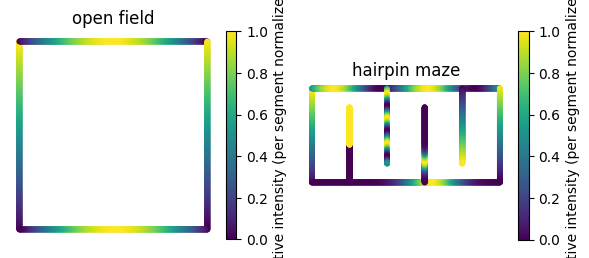

In [32]:
# 2D vision by raycasting — segment patterns via functions
import numpy as np
import matplotlib.pyplot as plt

# --------- Environment ---------
hairpin_maze = [
    [(0,0),(0,1)], [(0,1),(2,1)], [(2,1),(2,0)], [(0,0),(2,0)],  # outer boundaries
    [(2/5,0),(2/5,4/5)], [(4/5,1),(4/5,1/5)], [(6/5,0),(6/5,4/5)], [(8/5,1),(8/5,1/5)] # maze arms
]

open_field = [[(0,0),(0,1)],[(0,1),(1,1)],[(1,1),(1,0)],[(1,0),(0,0)]]

# --------- Sampling utilities ---------
def sample_segment(segment, n=300):
    (x0, y0), (x1, y1) = segment
    t = np.linspace(0.0, 1.0, n)
    x = x0 + (x1 - x0) * t
    y = y0 + (y1 - y0) * t
    return x, y, t

def normalize01(v):
    v = np.asarray(v, dtype=float)
    vmin, vmax = np.nanmin(v), np.nanmax(v)
    if np.isclose(vmax, vmin):
        return np.zeros_like(v)  # flat color if constant
    return (v - vmin) / (vmax - vmin)

# --------- Plotter ---------
def plot_environment_with_patterns(environment, funcs, ax = None,
                                   n_per_segment=400,
                                   point_size=8,
                                   show_outline=False):
    assert len(environment) == len(funcs), "funcs list must match number of segments"

    if ax is None:
      fig, ax = plt.subplots(figsize=(6, 6))

    scatters = []

    if show_outline:
        for seg in environment:
            xs, ys, _ = sample_segment(seg, n=2)
            ax.plot(xs, ys, linewidth=1, color="black")

    for seg, f in zip(environment, funcs):
        x, y, t = sample_segment(seg, n=n_per_segment)
        f = f if f is not None else (lambda u: u)
        raw = np.array([f(u) for u in t])
        cvals = normalize01(raw)
        sc = ax.scatter(x, y, c=cvals, s=point_size, cmap="viridis")
        scatters.append(sc)

    ax.set_aspect('equal', adjustable='box')
    ax.axis('off')

    if scatters:
        cbar = plt.colorbar(scatters[-1], ax=ax, fraction=0.046, pad=0.04)
        cbar.set_label("Relative intensity (per segment normalized)")

    return ax
# --------- Example intensity functions ---------
def linear(t): return t
def reverse_linear(t): return 1 - t
def sinusoid(t): return np.sin(2*np.pi*2*t)
def gaussian_bump(t, mu=0.5, sigma=0.12): return np.exp(-0.5*((t - mu)/sigma)**2)
def step(t): return 0.0 if t < 0.5 else 1.0

# Assign patterns to the 8 segments

#simplest case

#flexible for more complex environmets
hairpin_features = [
    linear,                        # left wall
    sinusoid,                      # top wall
    reverse_linear,                # right wall
    lambda t: gaussian_bump(t, 0.65, 0.1),  # bottom wall
    step,                          # first arm
    lambda t: np.sin(2*np.pi*3*t), # second arm
    lambda t: gaussian_bump(t, 0.3, 0.08),  # third arm
    lambda t: 0.2 + 0.6*t          # fourth arm
]
open_field_features = [linear, #left wall
                       lambda t: gaussian_bump(t, 0.5, 0.5), #top wall
                       reverse_linear, #right wall
                       lambda t: gaussian_bump(t, 0.5, 0.5)] #bottom wall

# --------- Show env ---------
fig, ax = plt.subplots(1,2, figsize=(6, 6))
ax[0] = plot_environment_with_patterns(open_field, open_field_features, ax = ax[0], n_per_segment=500, point_size=10)
ax[0].set(title ='open field')

ax[1] = plot_environment_with_patterns(hairpin_maze, hairpin_features, ax = ax[1], n_per_segment=500, point_size=10)
ax[1].set(title = 'hairpin maze')
fig.tight_layout()



In [33]:
## functions for 2D raycasting ##

import numpy as np

eps = 0.00001

def get_ray(position, angle, radius = 10):
    '''returns a ray as a list of tuples (start point and end point)
    Parameters
    ---------
    Angle: int
      angle of ray relative to agent in degrees'''
    endpoint = (position[0] + radius * np.cos(np.pi / 180 * angle),
                position[1] + radius * np.sin(np.pi / 180 * angle))
    return np.stack([position, endpoint])

def get_intersection_point(ray, segment, smallest_r=None):
  '''Honestly just copying some hard-coded geometry.
    Finding intersection points of two line segments.'''
  #initialise outputs as None
  intersection_point = None
  r = None
  A, B = segment    # segment is a list of two tuples [(x1, y1), (x2, y2)]
  C, D = ray    # ray is a list of two tuples [(x3, y3), (x4, y4)]

  denominator = (D[0] - C[0]) * (B[1] - A[1]) - (B[0] - A[0]) * (D[1] - C[1])

  if abs(denominator) < eps: # Avoid division by zero
      return None, None

  r = ((B[0] - A[0]) * (C[1] - A[1]) - (C[0] - A[0]) * (B[1] - A[1])) / denominator

  if (r + eps) < 0:
      return None, None
  if smallest_r is not None and smallest_r < r:
      return None, None

  s = ((A[0] - C[0]) * (D[1] - C[1]) - (D[0] - C[0]) * (A[1] - C[1])) / denominator

  if (s + eps) < 0 or (s - eps) > 1:
      return None, None

  # Return a tuple (x, y, r)
  intersection_point = ( s * (B[0] - A[0]) + A[0],
                          s * (B[1] - A[1]) + A[1])
  return intersection_point, r

def project_to_segment(intersection_point,segment):
  '''Takes 2D coordinate along segment and projects onto segment.
  Returns 1D number corresponding to how far along segment you are.
  This is a scalar projection and exactly what dot products are for.'''
  segment_vector = np.array(segment[1]) - np.array(segment[0])
  point_vector = np.array(intersection_point) - np.array(segment[0])
  scalar_projection = np.dot(point_vector, segment_vector) / np.linalg.norm(segment_vector)
  return scalar_projection


def get_closest_intersection_points(rays, segments, pattern_funcs):
  '''Take a list of rays and segments
    returns the intersection point of each ray to the nearest segment, alongside distance. '''
  all_points = []
  all_distances = []
  all_features = []
  for ray in rays:
    ray_points = []
    ray_distances = []
    ray_features = []
    for i, segment in enumerate(segments):
      intersection_point, distance = get_intersection_point(ray, segment)
      if intersection_point is not None:
        ray_points.append(intersection_point)
        ray_distances.append(distance)
        ray_features.append(pattern_funcs[i](project_to_segment(intersection_point,segment)))
    if len(ray_points)>0:
      nearest_point = ray_points[np.argmin(ray_distances)]
      all_points.append(ray_points[np.argmin(ray_distances)])
      all_distances.append(ray_distances[np.argmin(ray_distances)])
      all_features.append(ray_features[np.argmin(ray_distances)])

  return all_points, all_distances, all_features



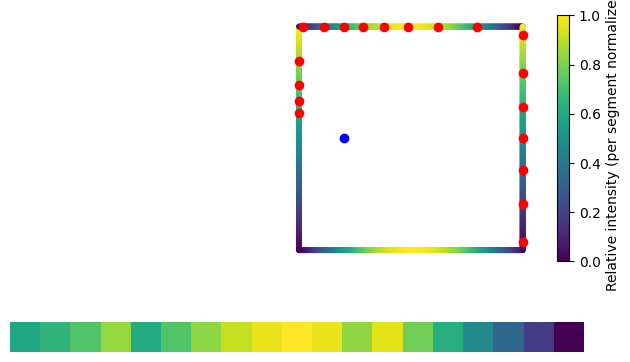

In [34]:
## Testing
current_position = (0.2,0.5)

fig, ax = plt.subplots(2,1)

ax[0] = plot_environment_with_patterns(open_field, open_field_features, ax = ax[0], n_per_segment=500, point_size=10)
ax[0].scatter(current_position[0],current_position[1], color ='blue', zorder = 1)
head_direction = -30
angles = np.linspace(0,180,19) +head_direction
rays = [get_ray(current_position, x, radius = 20) for x in angles]
intersection_points, distances, features = get_closest_intersection_points(rays, open_field, open_field_features)

for point in intersection_points:
    ax[0].scatter(point[0],point[1], color ='red', zorder =3)

#inverting indices below will render left-right rather than along the counter-clockwise angle
feature_img = np.array(features)[None,::-1]
#distace_img = np.array(distances)[None,::-1]
ax[1].imshow(feature_img, origin = 'lower')
ax[1].axis('off')
#ax[2].imshow(distace_img, origin = 'lower', cmap = 'jet')
#ax[2].axis('off')
fig.tight_layout()

## Trajectories with RatInABox

In [35]:
# Let's generate a trajectory with RatInABox!

!pip install RatInABox

100%|██████████| 100000/100000 [02:32<00:00, 653.61it/s]


(<Figure size 250x250 with 1 Axes>, <Axes: >)

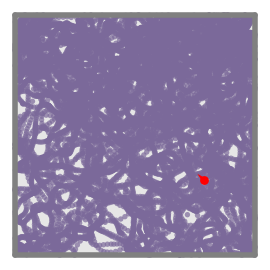

In [36]:
# leverage ratinabox to generate trajectory data and inputs
import ratinabox as riab
from tqdm import tqdm
import pandas as pd


#hairpin = riab.Environment(params = {'boundary':[[0,0],[0,1],[2,1],[2,0],[0,0]],
#                                  'walls':[[[2/5,0],[2/5,4/5]], [[4/5,5/5],[4/5,1/5]], [[6/5,0],[6/5,4/5]], [[8/5,1],[8/5,1/5]]]})

env = riab.Environment() #params = {'boundary':[[0,0],[0,1],[2,1],[2,0],[0,0]]} if using hairpin_maze to enlarge boundary
env.walls = np.array(open_field)
#env.plot_environment()
Ag = riab.Agent(env, params = {'dt':1/60})

traj_length = 100000
for i in tqdm(range(traj_length)):
  Ag.update()

history_df = pd.DataFrame(Ag.history)
Ag.plot_trajectory()

In [37]:
# now we have positions, velocities, and head directions.
# We now run over position and head direction to get the visual features at each time point
import numpy as np
history_df['hd_degrees'] = history_df['head_direction'].apply(lambda x: np.rad2deg(np.arctan2(x[1],x[0])))
history_df['vel_dir'] = history_df['vel'].apply(lambda x: np.rad2deg(np.arctan2(x[1],x[0])))

angles = np.linspace(0,180,32)
example_df = history_df.iloc[0:3]
velocities = []
visual_features = []
distances = []
for step in tqdm(history_df.itertuples()):
  #step is a pandas series with hd_degrees, pos, and vel attributes
  rays = [get_ray(step.pos, x+step.vel_dir, radius = 20) for x in angles]
  intersection_points, distances, features = get_closest_intersection_points(rays, env.walls, open_field_features)
  #action_vector = [np.deg2rad(step.vel_dir), np.linalg.norm(step.vel)] #head_direction + speed
  sensory_vector = np.stack(features) # visual feature for each ray
  distance_vector = np.stack(distances) # distance to boundary for each ray
  velocities.append(step.vel)
  visual_features.append(sensory_vector)
  distances.append(distance_vector) #might be superfluous

sensory_inputs = np.array(visual_features)
true_velocities = np.array(velocities)

100000it [05:20, 311.56it/s]


# Learning to integrate velocity

We don't want to have a loss that uses the true velocities, but instead learns this from the sensory inputs.

Bear in mind that the sensory features technically also vary as a function of head direction, so the velocity learnt here might be 3 dimensional rather than 2 dimensional (position x head direction).

The overarching aim is to estimate velocity, $\hat{v}$, given some change in sensory inputs over time, $i_t,i_{t+1}$.

The main paper describes four loss components, the first two being *critical* and the latter two *auxiliary*:

1. **Next state prediction**:
$$ \min d(\hat{i}_{t+2},i_{t+2}) $$

2. **Loop closure**:
$$ \min || \oint \hat{v}dt ||$$

3. **Shortcut estimation (actionability)**:
\begin{align}
\hat{v}_{1\to3} &= \hat{v}_{1\to 2} + \hat{v}_{2\to 3} \\
\hat{v}_{2\to4} &= \hat{v}_{2\to 3} + \hat{v}_{3\to 4} \\
\end{align}

4. **Isotropy (distance preservation)**:
$$\min var\{ ||\hat{v}_{t\to t+1} || \mid d(i_t,i_{t+1})<\theta \} $$


Let's unpack these (and the motivation behind each).

**(1) prediction error** is what allows us do self-supervised learning to extract velocity in the first place. How?

The general architecture takes the form of encoder-decoder nonlinear transformations. Inputs are the past two sensory observation ($i_t,i_{t+1}$) and it is trained to predict the next ($i_{t+2}$):

$$ \hat{i}_{t+2} = \text{decoder}(\hat{v}_{t\to t+1}), \qquad \hat{v}_{t\to t+1} = \text{encoder}(i_t,i_{t+1}) $$

Importantly, the estimated velocity is a dimension-bottle-necked vector $\hat{v}\in \mathbb{R}^{n_v}$, where $n_v<< n_i$.

**(2) loop closure** teaches the velocity to respect image manifold *structure*. For a trajectory that takes you back to the same image, the sum of the velocity vectors should be 0 !
Turns out that you don't need a perfect loop, but even just minimising velocities that bring you near the same sensory input is good.
In some sense, the sum of your velocities should scale with how much your sensory input has changed.

This is what makes 'shortcut estimation' and 'isotropy' *auxiliary*, since they also serve the purpose of teaching the velocity signal to respect the structure of the image manifold.

Note that the loops biases the loss signal only for >very similar< sensory inputs (a bit like a deja vu signal). We can do a similar thing by minimising the following:
$$ \mathbb{E}_{t,t'} \left[ \exp\left(-\frac{d(i_{t},i_{t'})^2}{2\sigma^2}\right) \cdot ||\sum_{i=t}^{t'} \hat{v}_{i\to i+1} ||\right]$$

where $d(i_t,i_{t'})$ is a distance metric between the two sensory imputs, such as mean squared error or the inverse dot product. Here we introduce $\sigma$ as a free parameter that regulates how much we discount far away / unrealted sensory inputs in the loss.



----
**Footnotes**:

1. Note that the 'triplet' $i_{t},i_{t+1},i_{t+2}$ training is to avoid learning image features in the prediction. It also implicitly assumes that the velocity change is small between sensory inputs (timesteps). This is apparently not necessary (see their supplementary information B.2). You can predict $\hat{i}_{t+1}$ using velocity estimated from the pair $(i_t,i_{t+1})$.

2. Strictly speaking, we are not replicating the paper here, rather simplifying it to check that we understand the core priniples underlying the model.




## Pytorch training

To do the above, we will take the generated trajectories and batch them into sequences of 100 examples (triplets $i_t,i_{t+1},i_{t+2}$ where $t\in [i,i+99]$).

Then for each example we accumulate the losses and also save out the velocities at each step (for regularisation at every batch).



In [38]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'


## DATASET DEFINITION ##

class SensoryDataset(Dataset):
    """Dataset for generating batched triplets of sensory inputs (t, t+1, t+2).
    Dataloader will return trajectory chunks shaped as:
    inputs: (n_batch, chunk_size, n_features*2)
    targets: (n_batch, chunk_size, n_features*2) """
    def __init__(self, sensory_inputs, chunk_size, device = DEVICE):
        """
        Args:
            sensory_inputs (np.ndarray): The sensory inputs array (n_steps, n_features).
            chunk_size (int): The size of each chunk to return.
        """
        self.sensory_inputs = torch.from_numpy(sensory_inputs).to(dtype=torch.float32, device=device)
        self.n_steps, self.n_features = self.sensory_inputs.shape
        self.chunk_size = chunk_size
        self.n_batches = (self.n_steps-1)//self.chunk_size
        self.n_samples = self.n_batches*self.chunk_size
        self.device=device

        self.inputs, self.targets = self.get_reshaped_data()

    def get_reshaped_data(self):
        inputs = torch.cat([self.sensory_inputs[:-1], #inputs time t
                            self.sensory_inputs[1:]], #inputs time t+1
                            dim = 1)[:self.n_samples,:]
        inputs = inputs.reshape(self.n_batches, self.chunk_size, self.n_features*2)
        targets = self.sensory_inputs[1:][:self.n_samples,:].reshape(self.n_batches,self.chunk_size,self.n_features)
        return inputs, targets

    def __len__(self):
        return self.n_batches

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]

## MODEL DEFINITION ##

class VelocityIntegrator(nn.Module):
  '''Following Iyer et al., 2024 code.
  Note that since their inputs are very high dimensional,
  they reduce i2 and expand v before combining. We skip that here.'''
  def __init__(self,
               n_features,
               v_dim,
               n_hidden,
               alpha, sigma,):
    super(VelocityIntegrator, self).__init__()
    self.I = n_features*2
    self.V = v_dim
    self.H = n_hidden
    self.O = n_features
    self.alpha = alpha
    self.sigma = sigma
    self.mse = nn.MSELoss()

    self.encoder = nn.Sequential(
        nn.Linear(self.I, self.I),
        nn.BatchNorm1d(self.I),
        nn.ReLU(),
        nn.Linear(self.I, self.I//2),
        nn.BatchNorm1d(self.I//2),
        nn.ReLU(),
        nn.Linear(self.I//2, self.I//4),
        nn.BatchNorm1d(self.I//4),
        nn.ReLU(),
        nn.Linear(self.I//4, 8),
        nn.BatchNorm1d(8),
        nn.ReLU(),
        nn.Linear(8, self.V),
        nn.Tanh())

    #instead of a deep decoder, we do an RNN (GRU architecture)
    self.rnn = nn.GRU(n_features+v_dim, n_hidden, batch_first=True)
    self.relu = nn.ReLU()
    self.decoder = nn.Linear(self.H, self.O)

  def forward(self, inputs, return_hidden = False):
    '''inputs is a tensor of shape (batch_size, input_size)
    Returns predictions (batch_size, output_size)
    and velocities (batch_size, v_dim)'''
    velocities = []
    predictions = []
    hidden = []
    for batch in inputs:
      v = self.encoder(batch)
      rnn_input = torch.cat([batch[:,:self.O],v], dim=-1).unsqueeze(0)
      rnn_hidden, _ = self.rnn(rnn_input)
      prediction = self.decoder(self.relu(rnn_hidden.squeeze()))
      velocities.append(v)
      predictions.append(prediction)
      hidden.append(rnn_hidden)
    if return_hidden:
      return torch.stack(predictions), torch.stack(velocities), torch.stack(hidden)
    else:
      return torch.stack(predictions), torch.stack(velocities)

  def compute_losses(self, predictions, velocities, targets):
    ## prediction loss ##
    prediction_loss = self.mse(predictions, targets)
    ## velocity regularisation ##
    # we compute similarity over all pairs in time over each trajectory
    dist_matrix = model.pairwise_mse(inputs[:,:,:model.O], targets)
    # discount to bias loss only for very similar sensory inputs
    dist_matrix = torch.exp(-dist_matrix/(2*self.sigma**2))
    vel_norm_matrix = model.pairwise_velocity_sum(velocities)
    structure_loss = torch.mean(dist_matrix*vel_norm_matrix)
    total_loss = self.alpha*prediction_loss + (1-self.alpha)*structure_loss
    return total_loss, prediction_loss, structure_loss

  def pairwise_mse(self, vectors_a, vectors_b):
    '''Takes vectors of shape (n_batch, n_seq, n_features)
    outputs matrix of shape (n_batch,n_seq,n_seq)'''
    # Compute pairwise Euclidean distances
    pairwise_distances = torch.cdist(vectors_a, vectors_b, p=2)
    # Square the distances and divide by the number of features to get MSE
    n_features = vectors_a.shape[-1]
    pairwise_mse_matrix = (pairwise_distances ** 2) / n_features
    return pairwise_mse_matrix

  def pairwise_velocity_sum(self, velocities):
    '''Slightly gnarly way of summing size of velocities for each pair t, t'''
    n_batch, n_seq, v_dim = velocities.shape
    vel_permuted = velocities.permute(0,2,1) #(n_batch, n_seq, v_di)
    sum_matrix = sum_matrix_from_tensor(vel_permuted) #(n_batch, v_dim, n_seq,n_seq)
    norm_matrix = torch.norm(sum_matrix, dim=1) #(n_batch, n_seq, n_seq)
    return norm_matrix



## utilities #


def sum_matrix_from_tensor(tensor):
  """
  Computes a matrix where the entry (i, j) is the sum of tensor elements
  from index i to j (inclusive) along the last dimension.
  The diagonal elements (i=j) are set to zero.

  Args:
    tensor (torch.Tensor): The input tensor of shape (..., N).

  Returns:
    torch.Tensor: A tensor of shape (..., N, N) where the last two dimensions
                  represent the sum from index i to j, with the diagonal set to zero.
  """
  # Compute the cumulative sum along the last dimension
  cumulative_sum = torch.cumsum(tensor, dim=-1)

  # Add a zero at the beginning of the cumulative sum for easier subtraction
  # The shape will be (..., N+1)
  zeros = torch.zeros_like(tensor[..., :1])
  cumulative_sum_padded = torch.cat((zeros, cumulative_sum), dim=-1)

  # Use broadcasting to compute the sum from i to j
  # sum(v[i:j+1]) = cumulative_sum_padded[..., j+1] - cumulative_sum_padded[..., i]

  # Expand cumulative_sum_padded for broadcasting: (..., 1, N+1)
  cumulative_sum_expanded = cumulative_sum_padded.unsqueeze(-2)
  # Select the sums up to j+1 (columns of the output matrix)
  # This selects cumulative_sum_padded[..., k] for k from 1 to N+1.
  # Shape (..., 1, N)
  sums_at_j_plus_1 = cumulative_sum_expanded[..., 1:]
  # Select the sums up to i (rows of the output matrix)
  # This selects cumulative_sum_padded[..., k] for k from 0 to N.
  # Shape (..., N, 1)
  sums_at_i = cumulative_sum_expanded[..., :-1].transpose(-2, -1)
  # The sum from i to j is sums_at_j_plus_1 - sums_at_i
  sum_matrix = sums_at_j_plus_1 - sums_at_i

  # Mask out values where i > j.
  # Create a mask where the upper triangle (inclusive of diagonal) is 1, lower is 0.
  N = tensor.shape[-1]
  mask = torch.triu(torch.ones(N, N, device=tensor.device)).unsqueeze(0) # Shape (1, N, N)
  # Expand the mask to match the batch dimensions of the sum_matrix
  mask = mask.expand_as(sum_matrix)
  sum_matrix = sum_matrix * mask
  sum_matrix = sum_matrix.triu(diagonal=1)   # Set the diagonal elements to zero

  return sum_matrix





In [39]:
import torch
from tqdm import tqdm

# Hyperparameters
chunk_size = 100
batch_size = 32
learning_rate = 3e-3
num_epochs = 50
v_dim = 3  # Velocity dimension
n_hidden = 256 #velocity integrator dimension
alpha = 1-1e-5
sigma = 0.1

# Initialize the dataset and data loaders
full_dataset = SensoryDataset(sensory_inputs, chunk_size=chunk_size, device=DEVICE)
train_size = round(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size = 1, shuffle = False)

# Initialize the model, loss function, and optimizer
n_features = full_dataset.n_features
model = VelocityIntegrator(n_features, v_dim, n_hidden, alpha, sigma).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

print(f"Starting training on {DEVICE}...")

losses = {'train_prediction':[],'train_structure':[],
          'val_prediction':[],'val_structure':[]}

val_velocities = []
for epoch in tqdm(range(num_epochs)):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    running_pred_loss = 0.0
    running_struct_loss = 0.0
    num_batches = 0

    for inputs, targets in train_loader:
        optimizer.zero_grad() # Zero the parameter gradients
        predictions, velocities = model(inputs) #forwards pass
        total_loss, prediction_loss, structure_loss = model.compute_losses(predictions, velocities, targets) #compute losses
        total_loss.backward() #backprop losses
        optimizer.step() #take an optim step

        # Accumulate statistics
        running_loss += total_loss.item()
        losses['train_prediction'].append(model.alpha*prediction_loss.item())
        losses['train_structure'].append((1-model.alpha)*structure_loss.item())

print("Training finished.")

fig, ax = plt.subplots(1,2)
ax[0].loglog(losses['train_prediction'])
ax[1].loglog(losses['train_structure'])

Starting training on cpu...


 22%|██▏       | 11/50 [10:11<36:07, 55.57s/it]


KeyboardInterrupt: 

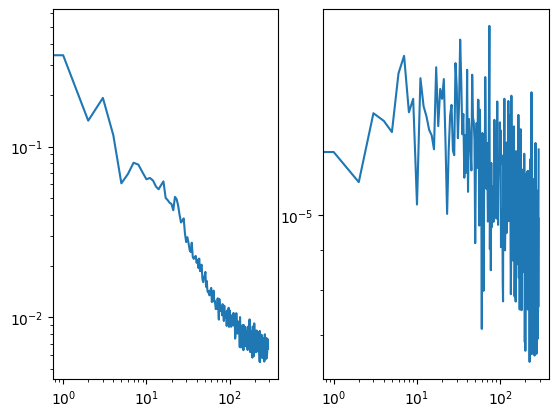

In [61]:

fig, ax = plt.subplots(1,2)
ax[0].loglog(losses['train_prediction'])
ax[1].loglog(losses['train_structure'])

In [40]:
val_predictions = []
val_velocities = []
with torch.no_grad():
    model.eval()  # Set the model to evaluation mode
    for inputs, targets in val_loader:
      predictions, velocities = model(inputs)
      val_predictions.append(predictions.cpu().numpy())
      val_velocities.append(velocities.cpu().numpy())
model_vel = np.stack(val_velocities).squeeze() #(n_batch, chunk_size, v_dim)
model_vel = model_vel.reshape(-1,model.V)


Text(0.5, 1.0, 'MSE:1.3617691365652718e-06')

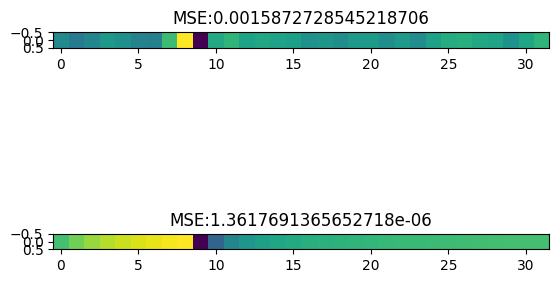

In [60]:
fig, ax = plt.subplots(2,1)
idx = 42
target_pred = targets[0,idx,:].cpu().unsqueeze(0)-predictions[0,idx].cpu().unsqueeze(0)
target_prev = targets[0,idx,:].cpu().unsqueeze(0)-inputs[0,idx,:model.O].cpu().unsqueeze(0)
ax[0].imshow(target_pred)
ax[0].set_title(f'MSE:{torch.mean(target_pred**2)}')
ax[1].imshow(target_prev)
ax[1].set_title(f'MSE:{torch.mean(target_prev**2)}')


Explained variance ratio per principal component (True Velocities):
  Principal Component 1: 0.5328
  Principal Component 2: 0.4672

Explained variance ratio per principal component (Model Velocities):
  Principal Component 1: 0.5117
  Principal Component 2: 0.3237
  Principal Component 3: 0.1646


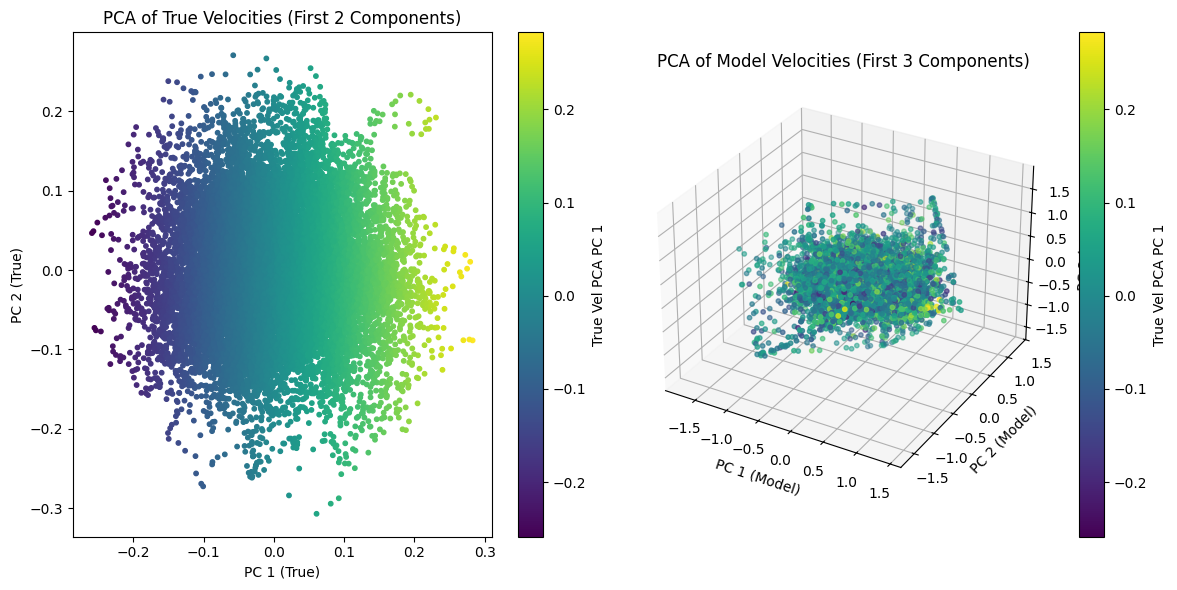

In [59]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming true_velocities numpy array is available
# Assuming model_vel numpy array is available (collected during validation)

# **Important:** Replace this with the actual variable containing your model's velocities
# For demonstration purposes, I'll create a dummy velocity array if model_vel is not found


# --- PCA on true_velocities ---
pca_true = PCA()
true_vel = true_velocities[-model_vel.shape[0]:]
dir_vel = np.stack([np.atan2(true_vel[:,1],true_vel[:,0]), #velocity direction
                    np.linalg.norm(true_vel, axis = 1)]).T #veloity magnitude
diff_vel = np.stack([(np.diff(dir_vel[:,0])),  #change in velocity direction
                     dir_vel[:-1,1]]).T        #velocity magnitude
transformed_true_vel = pca_true.fit_transform(true_vel)

# Summarize variance explained for true_velocities
explained_variance_ratio_true = pca_true.explained_variance_ratio_
print("Explained variance ratio per principal component (True Velocities):")
for i, ratio in enumerate(explained_variance_ratio_true):
    print(f"  Principal Component {i+1}: {ratio:.4f}")

# --- PCA on model_vel ---
pca_model = PCA()
transformed_model_vel = pca_model.fit_transform(model_vel)

# Summarize variance explained for model_vel
explained_variance_ratio_model = pca_model.explained_variance_ratio_
print("\nExplained variance ratio per principal component (Model Velocities):")
for i, ratio in enumerate(explained_variance_ratio_model):
    print(f"  Principal Component {i+1}: {ratio:.4f}")

# --- Plotting ---
fig = plt.figure(figsize=(12, 6))

# Determine if 3D plotting is possible
plot_3d_true = true_vel.shape[1] >= 3
plot_3d_model = model_vel.shape[1] >= 3

# Get coloring based on true_velocities PCA (first two components)
if true_vel.shape[1] >= 2:
    coloring = transformed_true_vel[:, :2]
    cmap = 'viridis' # Colormap for 2D coloring
else:
    coloring = transformed_true_vel[:, 0] if true_vel.shape[1] >= 1 else np.zeros(true_vel.shape[0])
    cmap = 'viridis' # Or any other colormap for 1D coloring


# Plot PCA of True Velocities
if plot_3d_true:
    ax1 = fig.add_subplot(121, projection='3d')
    scatter1 = ax1.scatter(transformed_true_vel[:, 0], transformed_true_vel[:, 1], transformed_true_vel[:, 2], c=coloring[:,0], cmap=cmap, s=10)
    ax1.set_xlabel('PC 1 (True)')
    ax1.set_ylabel('PC 2 (True)')
    ax1.set_zlabel('PC 3 (True)')
    ax1.set_title('PCA of True Velocities (First 3 Components)')
    fig.colorbar(scatter1, ax=ax1, label='True Vel PCA PC 1')

elif true_velocities.shape[1] >= 2:
    ax1 = fig.add_subplot(121)
    scatter1 = ax1.scatter(transformed_true_vel[:, 0], transformed_true_vel[:, 1], c=coloring[:,0], cmap=cmap, s=10)
    ax1.set_xlabel('PC 1 (True)')
    ax1.set_ylabel('PC 2 (True)')
    ax1.set_title('PCA of True Velocities (First 2 Components)')
    fig.colorbar(scatter1, ax=ax1, label='True Vel PCA PC 1')
elif true_velocities.shape[1] >= 1:
    ax1 = fig.add_subplot(121)
    scatter1 = ax1.scatter(transformed_true_vel[:, 0], np.zeros_like(transformed_true_vel[:, 0]), c=coloring, cmap=cmap, s=10)
    ax1.set_xlabel('PC 1 (True)')
    ax1.set_ylabel('')
    ax1.set_title('PCA of True Velocities (First Component)')
    fig.colorbar(scatter1, ax=ax1, label='True Vel PCA PC 1')
else:
     ax1 = fig.add_subplot(121)
     ax1.set_title('True Velocities PCA Not Possible')


# Plot PCA of Model Velocities colored by True Velocities PCA
if plot_3d_model:
    ax2 = fig.add_subplot(122, projection='3d')
    # Use the first component of coloring for simplicity in the color bar
    scatter2 = ax2.scatter(transformed_model_vel[:, 0], transformed_model_vel[:, 1], transformed_model_vel[:, 2], c=coloring[:,0] if coloring.ndim > 1 else coloring, cmap=cmap, s=10)
    ax2.set_xlabel('PC 1 (Model)')
    ax2.set_ylabel('PC 2 (Model)')
    ax2.set_zlabel('PC 3 (Model)')
    ax2.set_title('PCA of Model Velocities (First 3 Components)')
    fig.colorbar(scatter2, ax=ax2, label='True Vel PCA PC 1')
elif model_vel.shape[1] >= 2:
    ax2 = fig.add_subplot(122)
    scatter2 = ax2.scatter(transformed_model_vel[:, 0], transformed_model_vel[:, 1], c=coloring[:,0] if coloring.ndim > 1 else coloring, cmap=cmap, s=10)
    ax2.set_xlabel('PC 1 (Model)')
    ax2.set_ylabel('PC 2 (Model)')
    ax2.set_title('PCA of Model Velocities (First 2 Components)')
    fig.colorbar(scatter2, ax=ax2, label='True Vel PCA PC 1')
elif model_vel.shape[1] >= 1:
    ax2 = fig.add_subplot(122)
    scatter2 = ax2.scatter(transformed_model_vel[:, 0], np.zeros_like(transformed_model_vel[:, 0]), c=coloring, cmap=cmap, s=10)
    ax2.set_xlabel('PC 1 (Model)')
    ax2.set_ylabel('')
    ax2.set_title('PCA of Model Velocities (First Component)')
    fig.colorbar(scatter2, ax=ax2, label='True Vel PCA PC 1')
else:
    ax2 = fig.add_subplot(122)
    ax2.set_title('Model Velocities PCA Not Possible')


plt.tight_layout()
plt.show()

In [ ]:
# I think the model might be extracting egocentric velocities (which don't map onto PCs of velocity vectors)

# I think what hasn't been modelled here is an egocentric -> allocentric representation. How does the brain do this?